# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Download data
Download the data from  https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

if not os.path.isdir('../../../data/Mouse actin/'):
    os.mkdir('../../../data/Mouse actin/')

zipPath="../../../data/Mouse actin/Mouse_actin.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse actin/")


### Load Data
####  Ensure ```filename = sample_attempt2.tif``` and specify the ```dataName```  

In [3]:
path='../../../data/Mouse actin/'
fileName='sample_attempt2.tif'
dataName='mouseactin' # This will be used to name the care model

#### Noisy Data (Input to network)

In [4]:
data=imread(path+fileName)
nameModel=dataName+'_care'

#### Ground truth Data (Target of Network)

In [5]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [6]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 100, axis=0)
print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (100, 1024, 1024, 1) ; Shape of Target Image is  (100, 1024, 1024, 1)
Shape of `data` is  (100, 1024, 1024, 2)


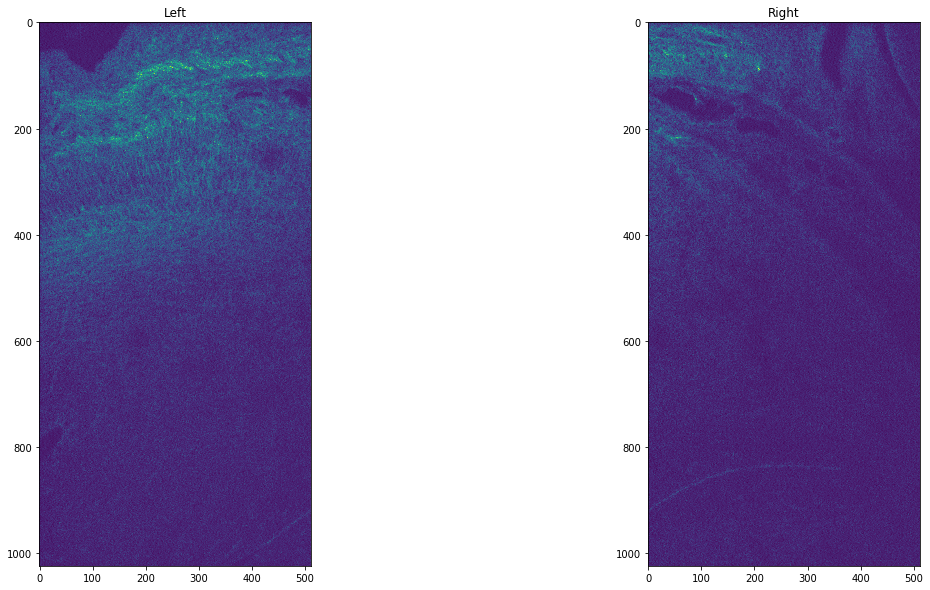

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(data[0,:,:512,0])
plt.title('Left')

plt.subplot(1,2,2)
plt.imshow(data[0,:,512:,0])
plt.title('Right')

plt.show()

# We now crop away the left portion of the data since this portion will be used later for testing
data = data[:, :, 512:, :]

### Create the Network and Train it
This can take a while. Ensure that `supervised` = `True`.

In [8]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

Epoch 0 finished      
avg. loss: 0.24203158728778362+-(2SEM)0.11967446724673288      
Epoch 1 finished      
avg. loss: 0.14231331907212735+-(2SEM)0.056187602175605394      
Epoch 2 finished      
avg. loss: 0.06288779624737799+-(2SEM)0.02821233030725855      
Epoch 3 finished      
avg. loss: 0.034885591547936204+-(2SEM)0.011207605562828007      
Epoch 4 finished      
avg. loss: 0.04655442130751908+-(2SEM)0.03263243613820116      
Epoch 5 finished      
avg. loss: 0.03817866868339479+-(2SEM)0.020147525570582712      
Epoch 6 finished      
avg. loss: 0.051949545321986076+-(2SEM)0.031865127492901324      
Epoch 7 finished      
avg. loss: 0.03624636181630194+-(2SEM)0.016085515063722126      
Epoch 8 finished      
avg. loss: 0.04296576431952417+-(2SEM)0.020358344313747646      
Epoch 9 finished      
avg. loss: 0.03307833480648696+-(2SEM)0.016562013576851824      
Epoch 10 finished      
avg. loss: 0.0223169369623065+-(2SEM)0.005679930140631481      
Epoch 11 finished      
avg. loss

Epoch 89 finished      
avg. loss: 0.032344126352109016+-(2SEM)0.013155029400627764      
Epoch 90 finished      
avg. loss: 0.022850127448327838+-(2SEM)0.012476543110765464      
Epoch 91 finished      
avg. loss: 0.029963902803137897+-(2SEM)0.019504606058672047      
Epoch 92 finished      
avg. loss: 0.02049786157440394+-(2SEM)0.007603724450375803      
Epoch 93 finished      
avg. loss: 0.031073054787702857+-(2SEM)0.01984048998864847      
Epoch 94 finished      
avg. loss: 0.02807426017243415+-(2SEM)0.01204019316031407      
Epoch 95 finished      
avg. loss: 0.023986425111070277+-(2SEM)0.0068060206119938725      
Epoch 96 finished      
avg. loss: 0.04043069842737168+-(2SEM)0.02329761504428138      
Epoch 97 finished      
avg. loss: 0.037324517779052255+-(2SEM)0.020491004134171667      
Epoch 98 finished      
avg. loss: 0.038004640210419896+-(2SEM)0.02409449817896738      
Epoch 99 finished      
avg. loss: 0.03658626363612712+-(2SEM)0.014067515443441148      
Epoch 100 finishe

Epoch 176 finished      
avg. loss: 0.022512508765794338+-(2SEM)0.009553288637713703      
Epoch 177 finished      
avg. loss: 0.021831692080013454+-(2SEM)0.008667815525813562      
Epoch 178 finished      
avg. loss: 0.024124447721987963+-(2SEM)0.008451241848117522      
Epoch   178: reducing learning rate of group 0 to 2.4414e-07.
Epoch 179 finished      
avg. loss: 0.04490644689649344+-(2SEM)0.022250641249997764      
Epoch 180 finished      
avg. loss: 0.020851300889626147+-(2SEM)0.010517921857753992      
Epoch 181 finished      
avg. loss: 0.026584251411259176+-(2SEM)0.01042906663247233      
Epoch 182 finished      
avg. loss: 0.02970169852487743+-(2SEM)0.014130847942839433      
Epoch 183 finished      
avg. loss: 0.02764110630378127+-(2SEM)0.012301200404322116      
Epoch 184 finished      
avg. loss: 0.032935203751549125+-(2SEM)0.017173122305229237      
Epoch 185 finished      
avg. loss: 0.025333283934742212+-(2SEM)0.014521375269129992      
Epoch 186 finished      
avg. lo

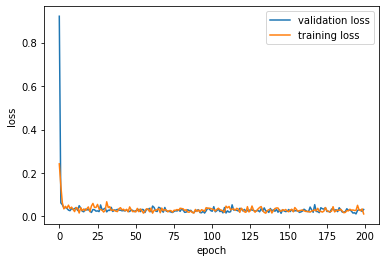

In [9]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()